In [69]:
# Import necessary libraries
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer

In [70]:
#Load the data
file_path = "/content/credit_card_fraud.csv"
data = pd.read_csv(file_path)

In [71]:
print("Initial data shape:", data.shape)
print(data.info())
data_drop_features = data.drop(columns=['Unnamed: 0.1','Unnamed: 0','first','last','street','city','zip','trans_num','unix_time','state','city_pop'])
print("Data shape after dropping columns:", data_drop_features.shape)

Initial data shape: (97748, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97748 entries, 0 to 97747
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0.1           97748 non-null  int64  
 1   Unnamed: 0             97748 non-null  int64  
 2   trans_date_trans_time  97748 non-null  object 
 3   cc_num                 97748 non-null  int64  
 4   merchant               97748 non-null  object 
 5   category               97748 non-null  object 
 6   amt                    97748 non-null  float64
 7   first                  97748 non-null  object 
 8   last                   97748 non-null  object 
 9   gender                 97748 non-null  object 
 10  street                 97748 non-null  object 
 11  city                   97748 non-null  object 
 12  state                  97748 non-null  object 
 13  zip                    97748 non-null  int64  
 14  lat                   

In [72]:
#Check data info
print(data_drop_features.info())
print(data_drop_features.describe())
print("Missing values:\n", data_drop_features.isnull().sum())
print("Unique values per column:\n", data_drop_features.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97748 entries, 0 to 97747
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trans_date_trans_time  97748 non-null  object 
 1   cc_num                 97748 non-null  int64  
 2   merchant               97748 non-null  object 
 3   category               97748 non-null  object 
 4   amt                    97748 non-null  float64
 5   gender                 97748 non-null  object 
 6   lat                    97748 non-null  float64
 7   long                   97748 non-null  float64
 8   job                    97748 non-null  object 
 9   dob                    97748 non-null  object 
 10  merch_lat              97748 non-null  float64
 11  merch_long             97748 non-null  float64
 12  is_fraud               97748 non-null  int64  
dtypes: float64(5), int64(2), object(6)
memory usage: 9.7+ MB
None
             cc_num           amt           

In [73]:
#Convert datetime transaction and dob is not right format
data_drop_features['trans_date_trans_time'] = pd.to_datetime(data_drop_features['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')
data_drop_features['dob'] = pd.to_datetime(data_drop_features['dob'], format='%Y-%m-%d')
print("Data types after datetime conversion:\n", data_drop_features.dtypes)

Data types after datetime conversion:
 trans_date_trans_time    datetime64[ns]
cc_num                            int64
merchant                         object
category                         object
amt                             float64
gender                           object
lat                             float64
long                            float64
job                              object
dob                      datetime64[ns]
merch_lat                       float64
merch_long                      float64
is_fraud                          int64
dtype: object


In [74]:
print(data_drop_features['is_fraud'].value_counts(normalize=True))

is_fraud
0    0.923211
1    0.076789
Name: proportion, dtype: float64


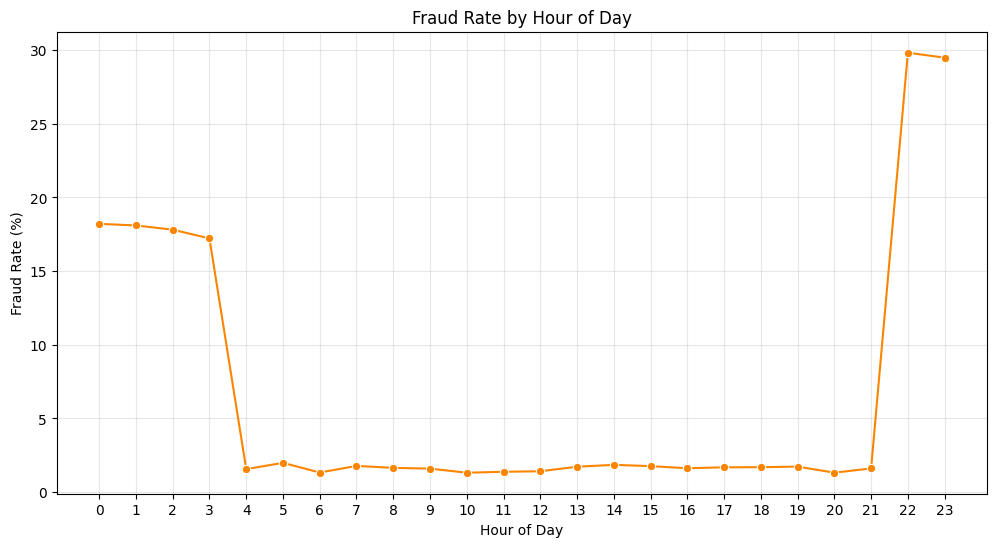

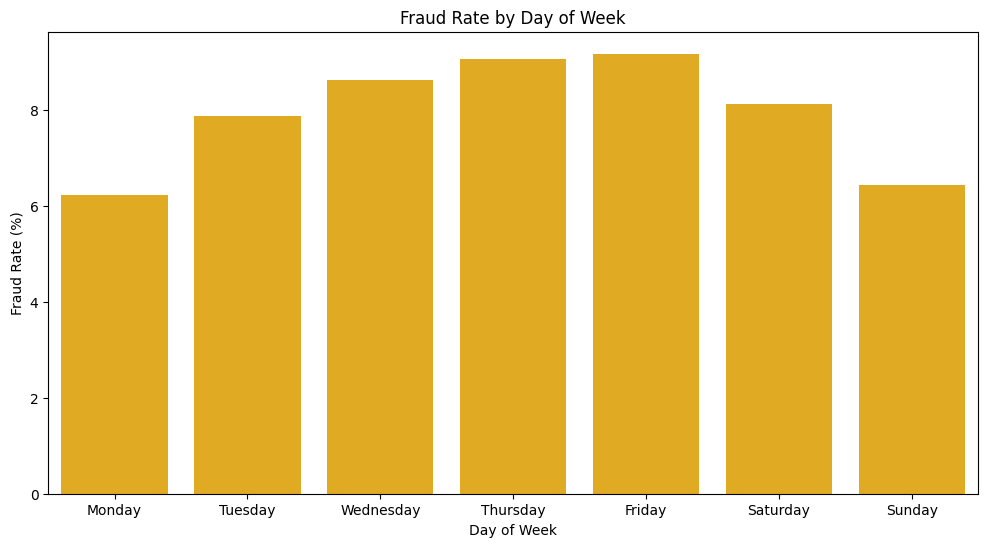

In [75]:
# Hour features
data_drop_features['hour'] = data_drop_features['trans_date_trans_time'].dt.hour

# Day features
data_drop_features['day_of_week'] = data_drop_features['trans_date_trans_time'].dt.dayofweek

#Visualize fraud by hour
plt.figure(figsize=(12, 6))
hour_fraud = data_drop_features.groupby('hour')['is_fraud'].mean() * 100
sns.lineplot(x=hour_fraud.index, y=hour_fraud.values, marker='o',color='#FB8500')
plt.title('Fraud Rate by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate (%)')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)

#Visualize fraud by day of week
plt.figure(figsize=(12, 6))
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_fraud = data_drop_features.groupby('day_of_week')['is_fraud'].mean() * 100
sns.barplot(x=days, y=day_fraud.values,  color='#FFB703')
plt.title('Fraud Rate by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Fraud Rate (%)')

# Night feature Features
data_drop_features['night_trans'] = data_drop_features['hour'].apply(lambda x: 1 if 0 <= x <= 3 else 0) #night transactions have high fraud rate

count                        97748
mean     4 days 19:52:36.978690101
std      7 days 00:17:08.051386260
min                0 days 00:00:00
25%                0 days 19:24:10
50%                2 days 13:14:47
75%                6 days 01:38:30
max              156 days 10:01:28
Name: time_diff, dtype: object


<ipython-input-76-29db5187c3f3>:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_fraud = data_drop_features.groupby('time_diff_group')['is_fraud'].agg(['mean', 'count']).reset_index()
<ipython-input-76-29db5187c3f3>:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(time_fraud['time_diff_group'], rotation=45, ha='right')


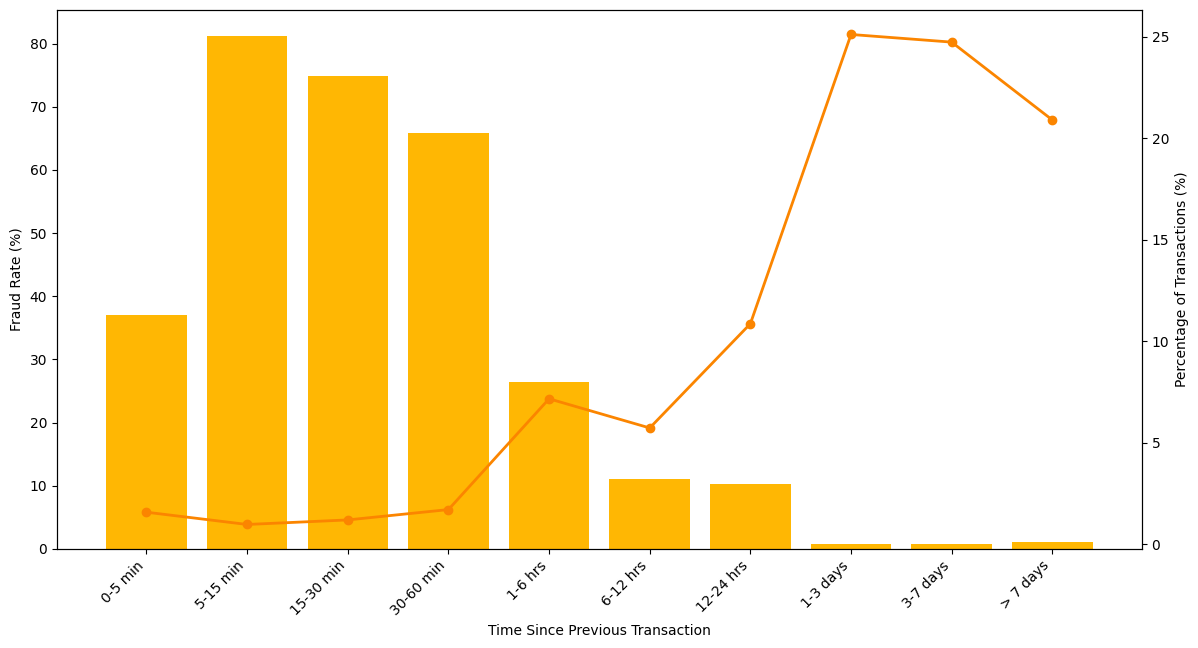

In [76]:
data_drop_features = data_drop_features.sort_values(by=['cc_num', 'trans_date_trans_time'])

data_drop_features['time_diff'] = data_drop_features.groupby('cc_num')['trans_date_trans_time'].diff()
data_drop_features['time_diff'] = data_drop_features['time_diff'].fillna(pd.Timedelta(seconds=0))
print(data_drop_features['time_diff'].describe())
data_drop_features['time_diff_minutes'] = data_drop_features['time_diff'].dt.total_seconds()/60
time_bins = [
    0,                  # 0 minutes
    5,                  # 0-5 minutes
    15,                 # 5-15 minutes
    30,                 # 15-30 minutes
    60,                 # 30-60 minutes (1 hour)
    360,                # 1-6 hours
    720,                # 6-12 hours
    1440,               # 12-24 hours (1 day)
    4320,               # 1-3 days
    10080,              # 3-7 days
    float('inf')        # > 7 days
]
time_labels = [
    '0-5 min',
    '5-15 min',
    '15-30 min',
    '30-60 min',
    '1-6 hrs',
    '6-12 hrs',
    '12-24 hrs',
    '1-3 days',
    '3-7 days',
    '> 7 days'
]

# Create the bins
data_drop_features['time_diff_group'] = pd.cut(
    data_drop_features['time_diff_minutes'],
    bins=time_bins,
    labels=time_labels,
    right=False
)

time_fraud = data_drop_features.groupby('time_diff_group')['is_fraud'].agg(['mean', 'count']).reset_index()
time_fraud['fraud_rate'] = time_fraud['mean'] * 100  # Convert to percentage
time_fraud['count_pct'] = time_fraud['count'] / time_fraud['count'].sum() * 100  # Percentage of transactions

fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot fraud rate as bars
bars = ax1.bar(time_fraud['time_diff_group'], time_fraud['fraud_rate'], color='#FFB703')
ax1.set_xlabel('Time Since Previous Transaction')
ax1.set_ylabel('Fraud Rate (%)')
ax1.tick_params(axis='y')
ax1.set_xticklabels(time_fraud['time_diff_group'], rotation=45, ha='right')

# Add a second y-axis for transaction counts
ax2 = ax1.twinx()
line = ax2.plot(time_fraud['time_diff_group'], time_fraud['count_pct'], 'o-', color='#FB8500', linewidth=2)
ax2.set_ylabel('Percentage of Transactions (%)')
ax2.tick_params(axis='y')

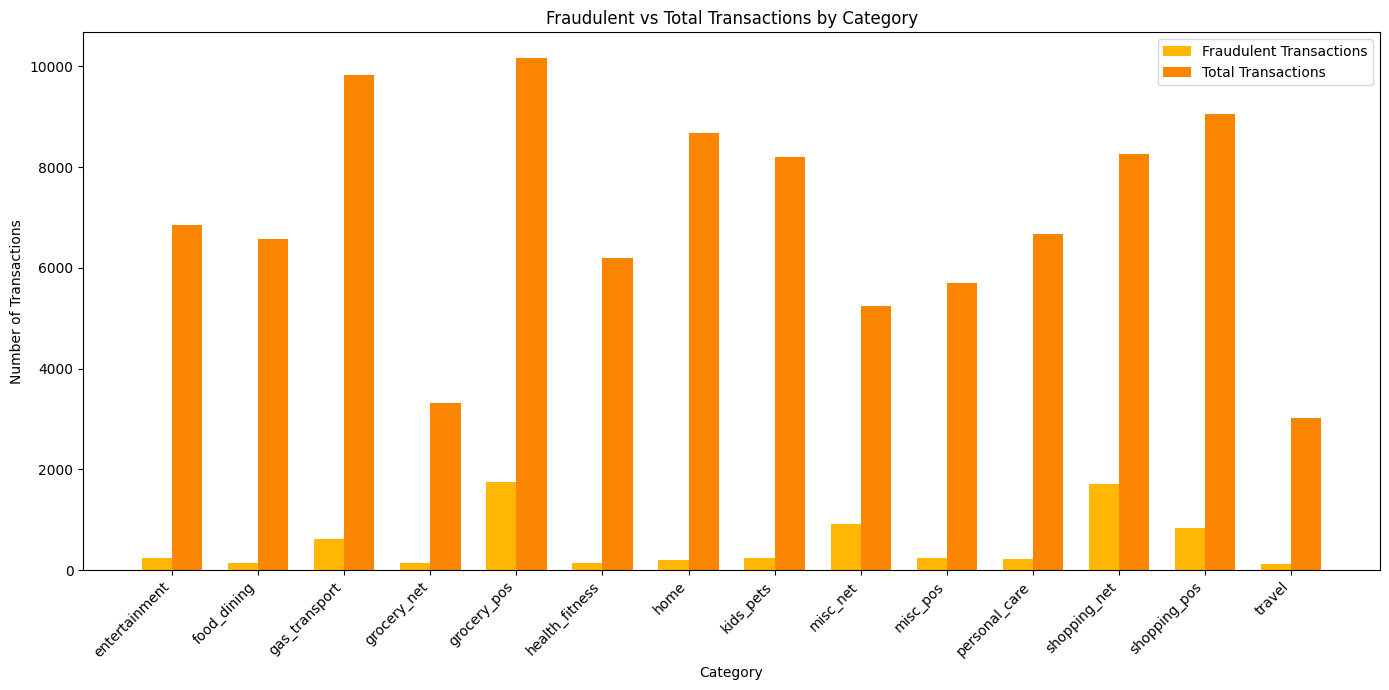

In [77]:
# Calculate fraudulent transaction counts per category
category_fraud_count = data_drop_features[data_drop_features['is_fraud'] == 1]['category'].value_counts()
category_total_count = data_drop_features['category'].value_counts()
categories = sorted(set(category_fraud_count.index) | set(category_total_count.index))

fraud_counts = [category_fraud_count.get(cat, 0) for cat in categories]
total_counts = [category_total_count.get(cat, 0) for cat in categories]
bar_width = 0.35
x = np.arange(len(categories))

# Create the bar chart
plt.figure(figsize=(14, 7))
bar1 = plt.bar(x - bar_width/2, fraud_counts, bar_width, label='Fraudulent Transactions', color='#FFB703')
bar2 = plt.bar(x + bar_width/2, total_counts, bar_width, label='Total Transactions', color='#FB8500')

# Set labels and title
plt.xlabel('Category')
plt.ylabel('Number of Transactions')
plt.title('Fraudulent vs Total Transactions by Category')
plt.xticks(x, categories, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [78]:
merchant_group = data_drop_features.groupby('merchant')['is_fraud'].mean().reset_index()
merchant_group['merchant_risk'] = pd.qcut(merchant_group['is_fraud'], q=3, labels=['low-risk', 'medium-risk', 'high-risk'])
data_drop_features = data_drop_features.merge(merchant_group[['merchant', 'merchant_risk']], on='merchant', how='left')

In [79]:
job_fraud = data_drop_features.groupby('job')['is_fraud'].mean().reset_index()
job_fraud['job_risk'] = pd.qcut(job_fraud['is_fraud'], q=3, labels=['low-risk', 'medium-risk', 'high-risk'])
data_drop_features = data_drop_features.merge(job_fraud[['job', 'job_risk']], on='job', how='left')

<ipython-input-80-8034f47fa8a6>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_fraud = data_drop_features.groupby('age_group')['is_fraud'].mean() * 100


Text(0, 0.5, 'Fraud Rate (%)')

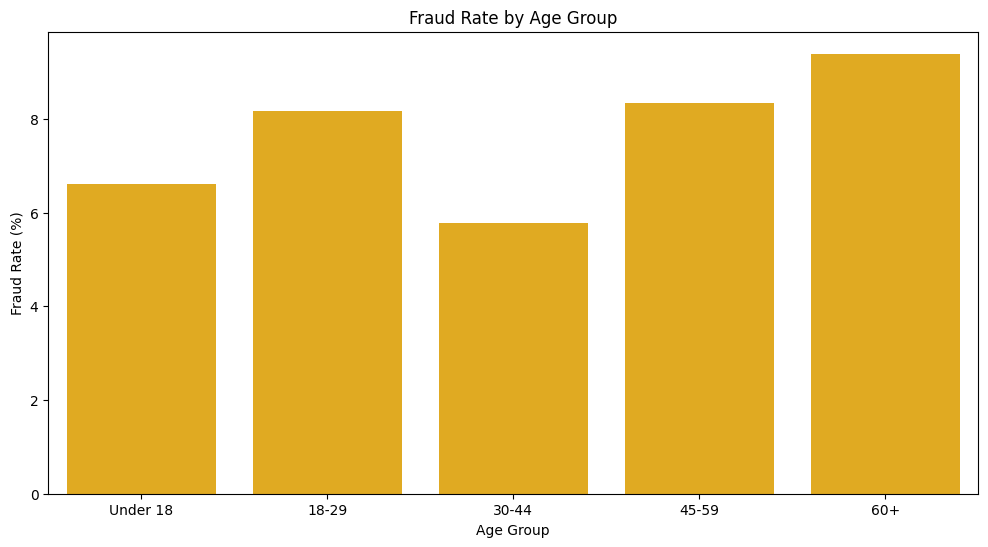

In [80]:
data_drop_features['dob'] = pd.to_datetime(data_drop_features['dob'])
defined_date = pd.to_datetime('2019-12-31')
data_drop_features['age'] = (defined_date - data_drop_features['dob']).dt.days // 365

bins = [0, 18, 30, 45, 60, 100]
labels = ['Under 18', '18-29', '30-44', '45-59', '60+']
data_drop_features['age_group'] = pd.cut(data_drop_features['age'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(12, 6))
age_fraud = data_drop_features.groupby('age_group')['is_fraud'].mean() * 100
sns.barplot(x=age_fraud.index, y=age_fraud.values,color='#FFB703')
plt.title('Fraud Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Fraud Rate (%)')


In [81]:
def calculate_geopy_distance(row):
    card_location = (row['lat'], row['long'])
    merchant_location = (row['merch_lat'], row['merch_long'])
    return geodesic(card_location, merchant_location).kilometers
data_drop_features['distance_km'] = data_drop_features.apply(calculate_geopy_distance, axis=1)
print(data_drop_features['distance_km'].describe())

count    97748.000000
mean        76.146272
std         29.014056
min          0.469721
25%         55.388372
50%         78.351432
75%         98.297578
max        146.541139
Name: distance_km, dtype: float64


<ipython-input-82-da181f977e72>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distance_fraud = data_drop_features.groupby('distance_bin')['is_fraud'].mean() * 100


Text(0, 0.5, 'Fraud Rate (%)')

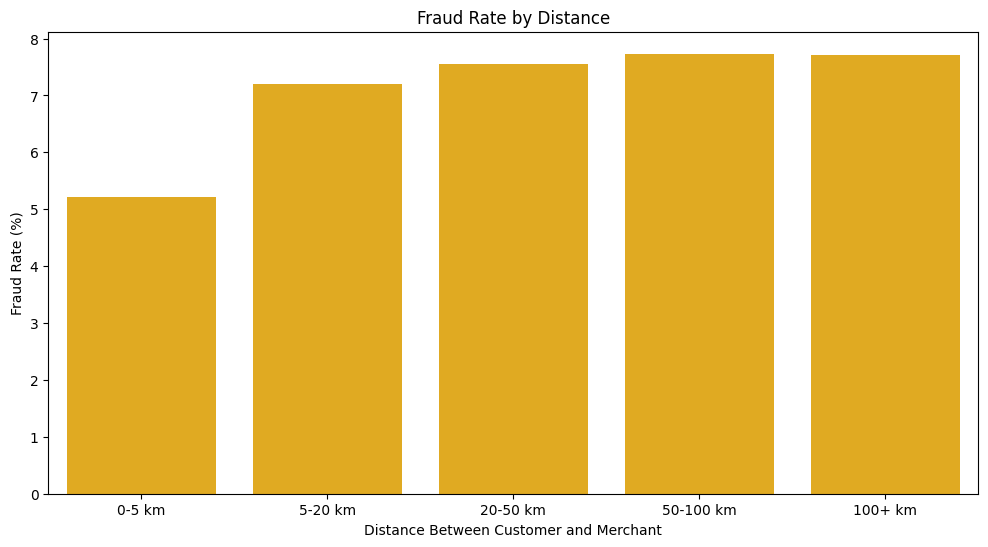

In [82]:
plt.figure(figsize=(12, 6))
data_drop_features['distance_bin'] = pd.cut(
    data_drop_features['distance_km'],
    bins=[0, 5, 20, 50, 100, float('inf')],
    labels=['0-5 km', '5-20 km', '20-50 km', '50-100 km', '100+ km']
)
distance_fraud = data_drop_features.groupby('distance_bin')['is_fraud'].mean() * 100
sns.barplot(x=distance_fraud.index, y=distance_fraud.values,color='#FFB703')
plt.title('Fraud Rate by Distance')
plt.xlabel('Distance Between Customer and Merchant')
plt.ylabel('Fraud Rate (%)')


count    97748.000000
mean       102.832444
std        217.047969
min          1.000000
25%         10.567500
50%         50.160000
75%         91.782500
max      15047.030000
Name: amt, dtype: float64


<ipython-input-83-3924db8acdb6>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  amount_fraud = data_drop_features.groupby('amount_bin')['is_fraud'].mean() * 100


Text(0, 0.5, 'Fraud Rate (%)')

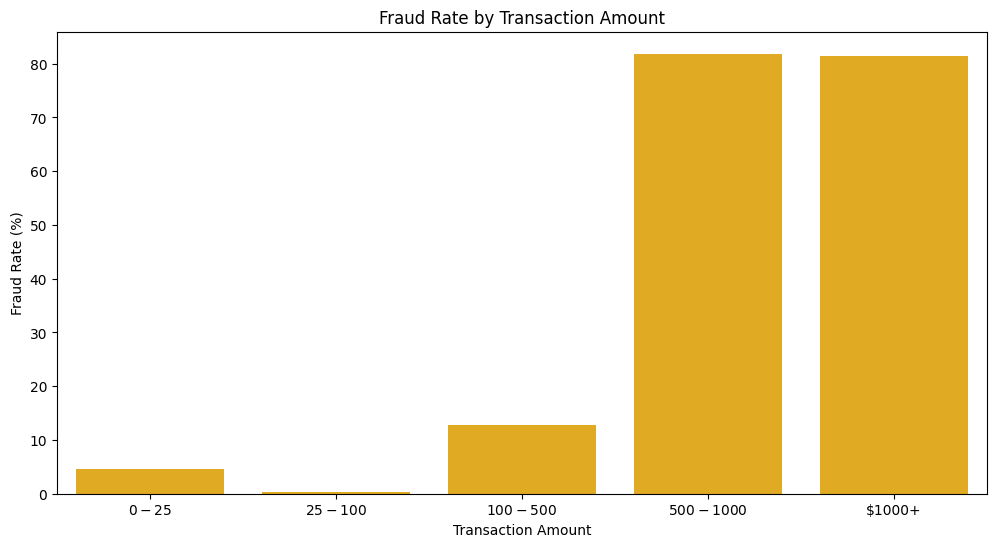

In [83]:
print(data_drop_features['amt'].describe())
plt.figure(figsize=(12, 6))
data_drop_features['amount_bin'] = pd.cut(
    data_drop_features['amt'],
    bins=[0, 25, 100, 500, 1000, float('inf')],
    labels=['$0-$25', '$25-$100', '$100-$500', '$500-$1000', '$1000+']
)
amount_fraud = data_drop_features.groupby('amount_bin')['is_fraud'].mean() * 100
sns.barplot(x=amount_fraud.index, y=amount_fraud.values,color='#FFB703')
plt.title('Fraud Rate by Transaction Amount')
plt.xlabel('Transaction Amount')
plt.ylabel('Fraud Rate (%)')

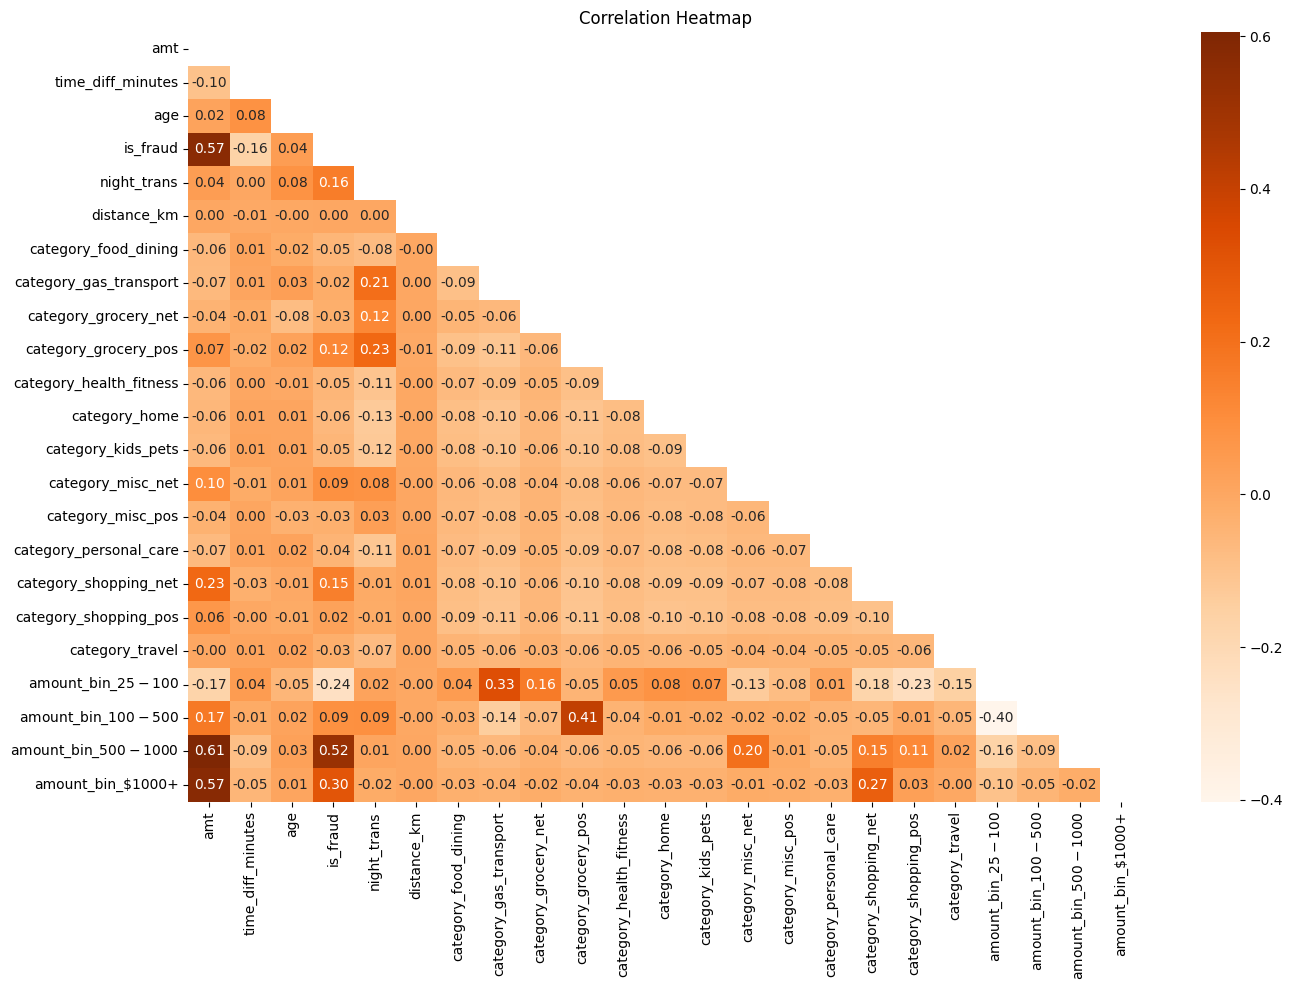

In [94]:
# Correlation Heatmap
plt.figure(figsize=(14, 10))
numeric_cols = ['amt','time_diff_minutes','age', 'is_fraud','distance_km']

category_encoded = pd.get_dummies(data_drop_features[['category','night_trans','amount_bin']], drop_first=True) # Pass a list of column names
correlation_data = pd.concat([data_drop_features[numeric_cols], category_encoded], axis=1)
correlation = correlation_data.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, mask=mask, annot=True, fmt='.2f', cmap='Oranges')
plt.title('Correlation Heatmap')
plt.tight_layout()

In [103]:
data_final = data_drop_features[['category','amt','time_diff_group','merchant_risk','is_fraud','job_risk',
                                 'age_group','night_trans']]


2. Build Models + Evaluation Graphs
*   Because imbalance fraud-non-fraud (92% - 8%), use SMOTE
*   Models used: base-line linear regression, ensemble random forest, gradient boositng
*   Plot heatmap 3 models, ROC curve



In [105]:
def build_and_evaluate_models(data_final):
    """Build and evaluate multiple models for fraud detection"""
    # Separate features and target
    X = data_final.drop('is_fraud', axis=1)
    y = data_final['is_fraud']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Define categorical and numerical features
    categorical_features = ['category', 'job_risk', 'age_group','time_diff_group','merchant_risk']
    numerical_features = X.columns.drop(categorical_features).tolist()

    # Initialize preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ],
         remainder='passthrough'
    )

    # Initialize preprocessing and models
    smote = SMOTE(random_state=42, sampling_strategy=0.3)

    # Adjusted parameters for imbalanced data
    models = {
        'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000),
        'Random Forest': RandomForestClassifier(
            class_weight='balanced',
            n_estimators=100,
            min_samples_leaf=5,
            max_depth=10
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100,
            subsample=0.8,
            max_depth=5,
            min_samples_leaf=5,
            learning_rate=0.1
        )
    }

    # Store predictions and probabilities
    predictions = {}
    probabilities = {}

    # Train models and make predictions
    for name, model in models.items():
        pipeline = Pipeline([
            ('preprocessor', preprocessor), # Apply column transformer first
            ('smote', smote), # Then apply SMOTE
            ('classifier', model)
        ])

        # Train model
        pipeline.fit(X_train, y_train)

        # Store predictions and probabilities
        predictions[name] = pipeline.predict(X_test)
        probabilities[name] = pipeline.predict_proba(X_test)[:, 1]

    # Calculate metrics for each model
    metrics = []
    for model_name, y_pred in predictions.items():
        metrics.append({
            'Model': model_name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred),
            'ROC-AUC': roc_auc_score(y_test, probabilities[model_name])
        })

    # Create metrics DataFrame
    metrics_df = pd.DataFrame(metrics)
    print("\nModel Performance Metrics\n")
    print(metrics_df)

    # Create heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(metrics_df.set_index('Model'),
                annot=True,
                fmt=".3f",
                cmap="Oranges",
                cbar=True,
                linewidths=0.5)
    plt.title('Model Performance Metrics')
    plt.show()

    # Find and print best model
    best_model = metrics_df.loc[metrics_df['ROC-AUC'].idxmax(), 'Model']
    print(f"\nBest performing model based on ROC-AUC: {best_model}")

    return metrics_df


Model Performance Metrics

                 Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0  Logistic Regression  0.930537   0.527543  0.914298  0.669050  0.979940
1        Random Forest  0.977937   0.813844  0.924067  0.865461  0.993173
2    Gradient Boosting  0.988679   0.923654  0.929396  0.926516  0.997681


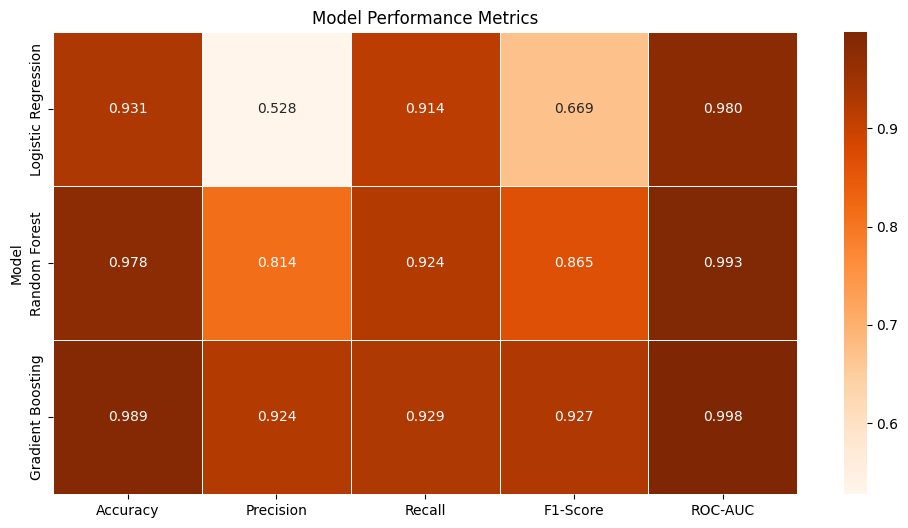


Best performing model based on ROC-AUC: Gradient Boosting


In [106]:
if __name__ == "__main__":
    metrics_df = build_and_evaluate_models(data_final)